In [1]:
import sys  
sys.path.insert(0, '../OMPbenders/')
%matplotlib widget

In [5]:
import pandas as pd
import gurobipy   as      gp
from   gurobipy   import GRB
#from MasterProblemOMP import MasterProblem
#from SubProblemOMP import SubProblem
sys.path.insert(0, '../AuxiliarCodes/')
%matplotlib widget
from plotDrawpointsPoints import plotDrawpointsPoints
from plotGurobiOpenPitSolution import plotGurobiOpenPitSolution
from plotIntegratedOmpSolution import plotIntegratedOmpSolution
from plotOmpOpenPitSolution import plotOmpOpenPitSolution
from plotUndergroundSolution import plotUndergroundSolution

Se cambió la definición de rho_v (el 1- no va), además se redifinió self.numberOfConstraints (se definió self.intNumberOfConstraints para calcular el óptimo). Se cambió como se calcula numberOfInvaiableBlocks

AL utilizar ql_t en 0.15 la solución objetivo se convierte en 0.0, estamos usando Ton * %Cu como ql, ¿Esta bien???, como se aplica ql, sobre cada bloque o sobre la suma de estos?, hay que cambiar la función de OMPsubproblem en función de esto 

In [6]:
#path = "C:/Users/willi/OneDrive/Escritorio/Magister/Tesis-Magister/Database/undergroundModel/" #Notebook
path = "/home/williams/Tesis-Magister/Databases/"
#path = "C:/Users/Williams Medina/Desktop/Tesis Magister/Tesis-Magister/ThesisCode/MainCode/Databases/undergroundModel/" #Desktop
undergroundDatabaseName = 'Modelo_F_OG.xlsx'
openPitDatabaseName = 'Modelo_F_OG.xlsx'
#openPitDatabaseName = 'modelo_reblogeado.xlsx'

In [7]:
if undergroundDatabaseName == openPitDatabaseName:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = undergroundMineDataframe
else:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = pd.read_excel(path + openPitDatabaseName, engine="openpyxl") #Notebook

In [8]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
import gurobipy   as     gp
from   gurobipy   import GRB
from drawpointFunction  import drawpointFunction
from globalFunctions import getNumberOfBlocksInADimension
from itertools import chain
from functools import reduce


class MasterProblem:
    #Underground Model + Crown Pillar Restrictions.
    def __init__(self, database, numberOfPeriods, colHeight, minColHeight,pos_x,pos_y,pos_z,pos_x_f,pos_y_f):
        self.database = database
        self.numberOfPeriods = numberOfPeriods
        self.DP_init = 0       #### Tipo de extracción
        self.desc = 0.1
        self.colHeight = colHeight#630#300
        self.minColHeight = minColHeight#0.20
        self.pos_x = pos_x     
        self.pos_y = pos_y   
        self.pos_z = pos_z
        self.pos_x_f = pos_x_f     
        self.pos_y_f = pos_y_f  
        self.p_t = 3791.912
        self.orientationToExtractTheDrawpoints = 0

    def setParameters(self):
        self.getUndergroundVariablesFromCSV()
        self.getUndergroundInfo()
        self.setUndergroundParameters()
        self.setUndergroundMineLimits()
        self.setUndergroundVariables()
        #self.setVandB_vParameters()
    
    def getUndergroundVariablesFromCSV(self):
        self.undergroundBlocksLenght = self.database['X'].to_dict()             
        self.undergroundBlocksWidth  = self.database['Y'].to_dict()             
        self.undergroundBlocksHeight = self.database['Z'].to_dict()             
        self.undergroundBlockTonnage = self.database['Ton'].to_dict()              
        self.undergroundBlockMineral  = self.database['Mineral'].to_dict()          
        self.undergroundBlockRecovery  = self.database['Recuperación'].to_dict()     
        self.undergroundCopperLaw  = self.database['%Cu'].to_dict()
        self.undergroundExtractionFixedCosts = self.database['CPlanta CA'].to_dict()
        self.undergroundVariableExtractionCosts = self.database['CMina CA'].to_dict()
        self.undergroundCP_S = self.database['CPlanta S'].to_dict()
        self.undergroundCM_S = self.database['CMINA S'].to_dict() 
    
    def getUndergroundInfo(self):
        self.undergroundBlocks = [i for i in range(len(self.undergroundBlocksLenght.values()))]

    def setUndergroundParameters(self):
        #Underground Parameters
        self.t_S   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.MU_mt = {period : 25806600.0/1  for period in range(self.numberOfPeriods)} #Tonleage es mina
        self.ML_mt = {period : 0/3  for period in range(self.numberOfPeriods)}
        self.MU_pt = {period : 17777880.0/1  for period in range(self.numberOfPeriods)}#Mineral es planta
        self.ML_pt = {period : 0/3 for period in range(self.numberOfPeriods)}
        self.qU_dt = {period : 1 for period in range(self.numberOfPeriods)}
        self.qL_dt = {period : 0.0001 for period in range(self.numberOfPeriods)}
        self.A_d   = {period : 2 for period in range(self.numberOfPeriods)}
        self.NU_nt = {period : 59 for period in range(self.numberOfPeriods)} 
        self.NL_nt = {period : 0 for period in range(self.numberOfPeriods)}
        self.N_t   = {period : 59* (1 + period) for period in range(self.numberOfPeriods)}
        self.RL_dt = {period : 0.2 for period in range(self.numberOfPeriods)}
        self.RU_dt = {period : 1 for period in range(self.numberOfPeriods)}

    def setUndergroundMineLimits(self):
        self.undergroundBlocksLenghtLimits = getNumberOfBlocksInADimension(self.undergroundBlocksLenght)
        self.undergroundBlocksWidthLimits = getNumberOfBlocksInADimension(self.undergroundBlocksWidth)
        self.undergroundBlocksHeightLimits = getNumberOfBlocksInADimension(self.undergroundBlocksHeight)

    def setUndergroundVariables(self):
        self.drawpoint, self.G_d, self.Q_d,self.q_d, self.C_pdt, self.C_mdt, self.predecessor, self.x_draw,self.y_draw, self.z_draw, self.drawpoints_blocks = drawpointFunction(
                        self.pos_x, self.pos_y, self.pos_z, self.colHeight, self.DP_init, self.undergroundBlocksLenghtLimits, self.undergroundBlocksWidthLimits, self.undergroundBlocksHeightLimits, self.undergroundBlockTonnage, self.undergroundCP_S, self.undergroundCM_S, self.undergroundBlockMineral,
                        self.undergroundCopperLaw, self.pos_x_f, self.pos_y_f,self.orientationToExtractTheDrawpoints)
        self.predecessorDict = {}
        self.predecessorDict[0] = []
        self.predecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            if self.predecessor[i][0] not in self.predecessorDict.keys():
                self.predecessorDict[self.predecessor[i][0]] = []
            self.predecessorDict[self.predecessor[i][0]].append(self.predecessor[i][1])

    def setModelandGetResults(self):
        self.objValue, self.variableValues, self.runtime, self.gap = self.setUndergroundModel()

    def setModel(self):                
        self.undergroundModel = gp.Model(name = 'Modelo Integrado')
        self.undergroundModel.Params.TimeLimit = 3600
        self.undergroundModel.Params.OutputFlag = 0

        # Underground  Model

              #14. Naturaleza de las variables
        self.x_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="x_d")
        self.y_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.CONTINUOUS, name="y_d")
        self.z_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="z_d")

        #1. Restricción sobre la cantidad de tonelaje máxima y mínima a extraer en cada periodo.
        Ton_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti]*self.G_d[d] for d in self.drawpoint) <= self.MU_mt[ti] for ti in self.t_S),
                                            "Min_max")
        
        Ton_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.G_d[d] for d in self.drawpoint) >= self.ML_mt[ti] for ti in self.t_S),
                                            "Min_min")
        #2. Restricción sobre la cantidad de material máxima y mínima a procesar en cada periodo.
        Mat_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) <= self.MU_pt[ti] for ti in self.t_S),
                                            "Mat_max")

        Mat_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) >= self.ML_pt[ti] for ti in self.t_S)
                                            , "Mat_min")

        
        #3. Rango de leyes máximas y mínimas a procesar
        GQC_low = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) >=
                                self.qL_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_low")
        
        GQC_Up = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) <=
                                self.qU_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_Up")

        #4. Todos los puntos de extracción deben ser iniciados en el largo de la extracción
        Drawp_init = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for ti in self.t_S) == 1 for d in self.drawpoint), "Drawp_init")

        #5. Los puntos de extracción deben ser activados al menos en el mismo periodo para que se inicie la extracción 
        Drawpextract_61 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, tau] for tau in range(ti+1)) >= self.z_dt[d, ti]  
                                            for d in self.drawpoint for ti in self.t_S), "Drawpextract_61")


        #6. Existe una cantidad máxima y mínima de drawpoints a abrir en cada periodo.
        Drawpextract_64_1 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.NU_nt[ti] for ti 
                                                        in self.t_S)
                                                        ,"Drawpextract_64_1")
        Drawpextract_64_2 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) >= self.NL_nt[ti] for ti 
                                                        in self.t_S)
                                                        , "Drawpextract_64_2")

        #7. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        Drawpextract_65 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")


        #8. Si iniciamos la extracción de un drawpoint esta debe durar por su duraci ́on determinada.
        ## Un drawpoint solamente puede ser extraido por un preiodo pre determinado (A_d)
        Drawpextract_62 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for ti in self.t_S)  <= self.A_d[ti]  for d in self.drawpoint
                                                    for ti in self.t_S), "Drawp_62")

        ## Una vez se inicia extrayendo de un drawpoint, se continua extrayendo sin interrupción
        Drawpextract_63 = self.undergroundModel.addConstrs((self.A_d[ti] *(self.z_dt[d, ti] - self.z_dt[d, ti+1]) 
                                            - gp.quicksum(self.z_dt[d, tau] for tau in range(ti+1)) <= 0 
                                            for d in self.drawpoint for ti in range(0,max(self.t_S))), "Drawpextract_63")

        #9. Relación de variables, el porcentaje a extraer es 0 si no se extra un drawpoint.
        Drawpextract_66 = self.undergroundModel.addConstrs((self.y_dt[d, ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S),
                                                    "Drawpextract_66")

        #10. Existe una tasa m ́ınima de extracci ́on para cada drawpoint a extraer.
        Drawpextract_67_1 = self.undergroundModel.addConstrs((self.RL_dt[ti] * self.z_dt[d, ti]  <=  self.y_dt[d, ti] for d in self.drawpoint
                                                        for ti in self.t_S), "Drawpextract_67_1")

        #11. La altura a extraer debe ser mayor a una cantidad m ́ınima.
        rest_11 = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d,ti] for ti in self.t_S)>= self.minColHeight for d in self.drawpoint))

        #12. No podemos extraer más del 100 % de un drawpoint.
        Reserver_cnst = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] for ti in self.t_S) <= 1 for d in self.drawpoint),
                                                    "Reserver_cnst")

        #13. Si se activa un drawpoint, se extrae en ese periodo
        rest_13 = self.undergroundModel.addConstrs(self.x_dt[d,ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S)

        #14. Naturaleza de variables.

        #15. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        rest_15 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")
        
        #16. Restricción sobre el inicio de la extracci ́on de los drawpoints.


        alternative = self.undergroundModel.addConstrs(gp.quicksum(self.x_dt[a,s] for s in range(0,ti+1)) >= self.x_dt[d, ti] for d in self.drawpoint for ti in self.t_S for a in self.predecessorDict[d])
        #resta_prec = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[self.predecessor[l][0], m]*(max(self.t_S)-m+1) for m in self.t_S) <=
        #                            gp.quicksum(self.x_dt[self.predecessor[l][1], m]*(max(self.t_S)-m+1) for m in self.t_S)  
        #                            for l in range(len(self.predecessor))), "DP_Sup")

        
        #Conjuntos para el crown pillar

        #Restricciones del crown pillar
        #Variable 1 si y solo si el crown pillar esta ubicado en la elevaci ́on v, 0 en otro caso.
        test_w = {530: 0.0,
                570: 0.0,
                610: 0.0,
                650: 0.0,
                690: 0.0,
                730: 0.0,
                770: 0.0,
                810: 0.0,
                850: 0.0,
                890: 0.0,
                930: 1.0,
                970: 0.0,
                1010: 0.0,
                1050: 0.0,
                1090: 0.0,
                1130: 0.0,
                1170: 0.0,
                1210: 0.0,
                1250: 0.0,
                1290: 0.0}
        test_u = {0: 0.0,
            1: 0.0,
            2: 1.0,
            3: 1.0,
            4: 1.0,
            5: 1.0,
            6: 1.0,
            7: 1.0,
            8: 1.0,
            9: 1.0}
        
        self.w_v = self.undergroundModel.addVars(self.V, vtype=GRB.BINARY, name="w")
        #self.w_v = self.undergroundModel.addVars(self.V,lb=test_w, ub=test_w ,vtype=GRB.BINARY, name="w")
        #alfa = gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        #((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)
        
        #self.alfa = self.undergroundModel.addVar(vtype =GRB.CONTINUOUS, lb = alfa, ub = alfa, name="alfa")
        
        
        self.theta = self.undergroundModel.addVar(vtype=GRB.CONTINUOUS,name="theta")
        self.u_t = self.undergroundModel.addVars(self.t_S, vtype=GRB.BINARY, name="u")
        #self.u_t = self.undergroundModel.addVars(self.t_S,lb=test_u, ub=test_u ,vtype=GRB.BINARY, name="u")


        ##Código experimental
        #natu = self.undergroundModel.addConstr(gp.quicksum(self.u_t[t] for t in self.t_S) <= 4)
        time_rest = self.undergroundModel.addConstrs(self.u_t[t-1]<= self.u_t[t] for t in range(1, len(self.t_S)))
        limit_time = self.undergroundModel.addConstrs(self.y_dt[d,t] <= self.u_t[t] for d in self.drawpoint for t in self.t_S)

        pillar_2 = self.undergroundModel.addConstrs(gp.quicksum(self.y_dt[d, ti] 
                                                        for ti in self.t_S) <= self.rho_v[v] * self.w_v[v] + (1 - self.w_v[v]) for v in self.V for d in self.drawpoint)
       
        pillar_3 = self.undergroundModel.addConstr(gp.quicksum(self.w_v[v] for v in self.V) == 1)

        theta_restriction_1 = self.undergroundModel.addConstr(-gp.GRB.INFINITY <= self.theta)
        theta_restriction_2 = self.undergroundModel.addConstr(self.theta <= 9999999999)

         #Función objetivo
        self.undergroundObjectiveFunction = self.theta + gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        ((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)

        self.undergroundModel.setObjective(self.undergroundObjectiveFunction, GRB.MAXIMIZE)
        self.undergroundModel.Params.MIPGap = 0.05

    def optimizeModel(self):
        self.undergroundModel.optimize()
        #self.lista_variable_Integrado = (self.undergroundModel.getAttr(GRB.Attr.X, self.undergroundModel.getVars()))
        solucion = self.undergroundModel.objVal
        runtime = self.undergroundModel.Runtime
        gap_f = self.undergroundModel.MIPGap
        estimatedW_v = {key:value.X for key,value in self.w_v.items()}
        estimatedU_t = {key:value.X for key,value in self.u_t.items()}
        self.selectedHeight = [key for key,value in estimatedW_v.items() if value > 0][0]
        self.selectedTime = [key for key,value in estimatedU_t.items() if value > 0][0]
        #self.x_dt_values = self.undergroundModel.getAttr('X', self.x_dt)
        #self.y_dt_values = self.undergroundModel.getAttr('X', self.y_dt)
        #self.z_dt_values = self.undergroundModel.getAttr('X', self.z_dt)
        return estimatedW_v, estimatedU_t, self.theta

In [9]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')

from   gurobipy   import GRB
from globalFunctions import getNumberOfBlocksInADimension
from openPitFunctions import finalBlock
from itertools import chain
import re
import subprocess as sp


class SubProblem:
   def __init__(self, database, minHeightUnderground, maxHeightUnderground,numberOfPeriods, safetyLevel):
      self.database = database
      self.numberOfPeriods = numberOfPeriods
      self.minHeightUnderground = minHeightUnderground
      self.maxHeightUnderground = maxHeightUnderground
      self.safetyLevel = safetyLevel
      self.numberOfDestinations = 1
      self.basePrice = 3791.912
      self.desc = 0.1

   def setParameters(self):
      self.setOpenPitVariables()
      self.getOpenPitInfo()
      self.setOpenPitParameters()
      self.setOpenPitMineLimits()
      self.setPossibleHeights()
      self.setHeightSets()

   def execute(self, B_v, u_t, height,isFinalIteration = False):
      self.wHeight = height
      self.createOmpInput(B_v, u_t)
      return (self.executeOmp(isFinalIteration))

   def setOpenPitVariables(self):
      self.openPitBlocksLength = self.database['X'].to_dict() 
      self.openPitBlocksWidth = self.database['Y'].to_dict() 
      self.openPitBlocksHeight = self.database['Z'].to_dict() #Los bloques se orientan de abajo hacia arriba, el bloque 0 es el que esta más abajo, 784 bloques
      self.L_b = self.database['Ton'].to_dict() #openPitBlockTonnage
      self.o_b = self.database['Mineral'].to_dict() #openPitBlockMineral
      self.openPitBlockRecovery = self.database['Recuperación'].to_dict() #openPitBlockRecovery
      self.openPitCopperLaw = self.database['%Cu'].to_dict() #openPitCopperLaw
      self.c_pbt = self.database['CPlanta CA'].to_dict() #openPitPlantCapacity
      self.c_mbt = self.database['CMina CA'].to_dict() #openPitMineCapacity

   def getOpenPitInfo(self):
      self.openPitBlocks = [i for i in range(len(self.openPitBlocksLength.values()))]

   def setOpenPitParameters(self):
      #OpenPit Parameters
      self.t_C   = {period : period + 1 for period in range(self.numberOfPeriods)}
      self.RMu_t = {period : 2*25806600.0/1 for period in range(self.numberOfPeriods)}#Superior infinita, 0 por abajo Originales: 13219200
      self.RMl_t = {period : 0.0/3 for period in range(self.numberOfPeriods)}#Valor original 8812800.0
      self.RPu_t = {period : 2*17777880.0/1 for period in range(self.numberOfPeriods)}#Valor original 10933380.0
      self.RPl_t = {period : 0/3 for period in range(self.numberOfPeriods)}#Valor original 7288920.0 
      self.qu_t  = {period : 1 for period in range(self.numberOfPeriods)}#Leyes promedio maxima y minima.
      self.ql_t  = {period : 0.0001 for period in range(self.numberOfPeriods)}
      self.delta = {period: 0 for period in range(self.numberOfPeriods)}
      self.maxTimeOpenPit = self.t_C[max(self.t_C)]

   def setOpenPitMineLimits(self):
      self.openPitBlocksLengthLimits = getNumberOfBlocksInADimension(self.openPitBlocksLength)
      self.openPitBlocksWidthLimits = getNumberOfBlocksInADimension(self.openPitBlocksWidth)
      self.openPitBlocksHeightLimits = getNumberOfBlocksInADimension(self.openPitBlocksHeight)
      self.predecessorBlock = self.setPredecessorBlocks()

   def setPredecessorBlocks(self):
      self.predecessorBlocks = finalBlock(self.openPitBlocks, self.openPitBlocksLengthLimits,self.openPitBlocksWidthLimits, self.openPitBlocksHeightLimits)
  
   def setPossibleHeights(self):
      self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.openPitBlocksHeightLimits
   
   def setHeightSets(self):
      #Acá hay que redifinir self.B_v para que tenga las alturas de maxheight al sumarle el safetylvl

      self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
      self.B_v = {}
      self.rho_v = {v:( ((v- self.safetyLevel - self.minHeightUnderground)/(self.maxHeightUnderground - self.minHeightUnderground)) if v - self.minHeightUnderground > 0 else 0 ) for v in self.V}

      for v in self.V:
         numberOfBlocksBelowV = (self.openPitBlocksLengthLimits[3]*self.openPitBlocksWidthLimits[3])*((v-self.minHeight)/self.openPitBlocksHeightLimits[0])
         blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if not numberOfBlocksBelowV == 0]
         self.B_v[v] = blocksBelowV
         
   def createOmpInput(self, infeasibleBlocks, u_t):
      self.writeProblemFile(u_t)
      self.writeBlocksFile(infeasibleBlocks)
      self.writePrecFile()
      self.writeParamsFile()
   
   def writeProblemFile(self, u_t):
         with open('../FilesToExecuteOmpOpenPit/files/openPit.prob', 'w') as f:
            numberOfDestinations = 'NDESTINATIONS: ' + str(self.numberOfDestinations)
            numberOfPeriods = 'NPERIODS: ' + str(self.numberOfPeriods)
            objective = 'OBJECTIVE: 0 1'
            duration = 'DURATION: 2'
            discountRate = 'DISCOUNT_RATE: '+ str(self.desc)#/self.numberOfPeriods)
            
            tonUpConstraint = 'CONSTRAINT: 0 3 P * L '
            for rmu in self.RMu_t.values():
               tonUpConstraint +=str(rmu) + " "

            tonLowContraint = 'CONSTRAINT: 1 3 P * G '
            for rml in self.RMl_t.values():
               tonLowContraint +=str(rml) + " "
            
            matUpConstraint = 'CONSTRAINT: 2 4 P * L '
            for rpu in self.RPu_t.values():
               matUpConstraint +=str(rpu) + " "

            matLowConstraint = 'CONSTRAINT: 3 4 P * G '
            for rpl in self.RPl_t.values():
               matLowConstraint +=str(rpl) + " "
            
            #las siguientes dos restricciones tienen 0 en vez de qut y qlt ya que pasamos la desigualdad hacia la derecha en las lineas 144 y 145
            copperLawUpConstraint = 'CONSTRAINT: 4 5 B * L ' 
            for qut in self.qu_t.values():
               copperLawUpConstraint += "0 "

            copperLawLowConstraint = 'CONSTRAINT: 5 6 B * G '
            for qlt in self.ql_t.values():
               copperLawLowConstraint +="0 "

            infeasibleBlocks = 'CONSTRAINT: 6 7 P * L '
            for delta in self.delta.values():
               infeasibleBlocks +=str(delta) + " "
            
            durationConstraint = 'CONSTRAINT: 7 2 P * L '
            for u in u_t.values():
               durationConstraint += str(len(self.openPitBlocks) * (1-u)) + " "
            
            constraints = [tonUpConstraint, tonLowContraint, matUpConstraint, matLowConstraint, copperLawUpConstraint,copperLawLowConstraint,infeasibleBlocks, durationConstraint]
            self.numberOfConstraints = len(constraints)
            self.nConstraints = 'NCONSTRAINTS: ' + str(self.numberOfConstraints)
            f.write('{}\n{}\n{}\n{}\n{}\n{}\n'.format(numberOfDestinations, numberOfPeriods, objective, duration, discountRate, self.nConstraints))
            f.write('{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(*constraints))

   def writeBlocksFile(self, numberOfInvaiableBlocks):
      #print(f'Se optimizó el subproblema con {numberOfInvaiableBlocks} bloques infactibles')
      with open('../FilesToExecuteOmpOpenPit/files/openPit.blocks', 'w') as f:
         for block in self.openPitBlocks:
            index = block
            value = ((self.basePrice*self.openPitCopperLaw[block]-self.c_pbt[block])*self.o_b[block])-(self.c_mbt[block]*self.L_b[block])
            duration = 1 #Cuanto se demora en extraer el bloque
            ton = self.L_b[block]
            mineral = self.o_b[block]
            copperLawUpper = self.openPitCopperLaw[block] * self.L_b[block] - self.qu_t[0] * self.L_b[block]
            copperLawLower = self.openPitCopperLaw[block] * self.L_b[block] - self.ql_t[0] * self.L_b[block]

            #1 si no se puede extraer, 10977 última capa, los bloques van de abajo hacia arriba, 0 primer bloque de abajo, 10977 última capa hacia arriba, con 10975 la sol es vacia
            if block < numberOfInvaiableBlocks:
               f.write(('{} {} {} {} {} {} {} {}\n').format(index, value, duration, ton, mineral,copperLawUpper, copperLawLower, 1))
            else:
               f.write(('{} {} {} {} {} {} {} {}\n').format(index, value, duration, ton, mineral,copperLawUpper, copperLawLower, 0))
                 
   def writePrecFile(self):
      with open('../FilesToExecuteOmpOpenPit/files/openPit.prec', 'w') as f:
         for index,blockList in enumerate(self.predecessorBlocks):
            predecessorLine = str(len(blockList))
            for block in blockList:
               if block == index:
                  predecessorLine = " 0"
                  break
               else:
                  predecessorLine +=" " + str(block)
            f.write("{} {}\n".format(index, predecessorLine))
            
   def writeParamsFile(self):
      with open('../FilesToExecuteOmpOpenPit/params/openPit.params', 'w') as f:
         f.write("""USE_DISPLAY: 1
WRITE.LP.SOLUTION: 1
WRITE.IP.SOLUTION: 1
CPIT: 1
PP.ULTIMATE_PIT: 1
PP.FORCE_UPIT: 1
PP.EARLY_START: 1
PP.WASTE_OPTION: 1
PP.ELIM_NULL: 0
PP.TRANSITIVE_REDUCTION: 0
AG.USE_BLOCK_AGGREGATION: 0
AG.BLOCK_AGGREGATION: 0
OPTMETHOD: 0
CG.ONE_DESTINATION: 1
CG.IMPLICIT: 0
CG.USE_DISPLAY: 1
CG.MAX_ITER: -1
CG.TARGET_GAP: 0.0001
CG.MAX_TIME: -1
CG.USE_KSTEP: 0
CG.KSTEP_K: 10
CG.MASTER_NTHREADS: 4
CG.DISPLAY_DUALS: 1
HE.TOPOSORT: 1
HE.FTOPOSORT: 0
HE.NALPHA_POINTS: 50
HE.OPT_DESTINATIONS: 1
HE.NAIVE: 0
HE.NAIVE_INTSOLLIM: 1000
HE.NAIVE_EPGAP: 0.01
HE.NAIVE_TILIM: 14400
CP.DYNAMIC_CUTS: 0
CP.CLIQUES: 0
CP.MINW: 0
CP.DELAYED_PRECEDENCES: 0
CONSTRAINT_PROGRAMMING: 0
CPROG.GAP_LIMIT: 0.01
CPROG.CP_TIME_LIMIT: 28800
CPROG.EX_TIME_LIMIT: 28800
CPROG.HOT_START: 1
CPROG.NTHREADS: 8""")

   def executeOmp(self, isFinalIteration):
      output = sp.getoutput("./omp.sh ../FilesToExecuteOmpOpenPit/files/openPit.* ../FilesToExecuteOmpOpenPit/params/dbs_duals.params")
      #print(output)
      return self.getPiAndObjectiveValue(output, isFinalIteration)
   
   def getPiValues(self, output):
      pi_positions = [positions.start() for positions in re.finditer("rhs= 0.000000", output)]
      pi_t = dict.fromkeys(self.t_C,0)
      pi_indexes = [int(index) for index in range(self.numberOfPeriods * (self.numberOfConstraints -2), self.numberOfPeriods * (self.numberOfConstraints -1)) ]
      for pos in pi_positions:
         pi_value = float(output[pos-48: pos].split()[-3])
         pi_index = float(output[pos-48: pos].split()[-5])
         if pi_index in pi_indexes:
            period_index = pi_index - self.numberOfPeriods * (self.numberOfConstraints - 2)
            pi_t[period_index] = pi_value
      return pi_t
   
   def getSigmaValues(self, output):
      sigma_indexes = [index for index in range(self.numberOfPeriods * (self.numberOfConstraints -1), self.numberOfPeriods * (self.numberOfConstraints)) ]
      sigma_t = dict.fromkeys(self.t_C,0)
      for index in sigma_indexes:
         strToFind = "BZ_DUAL: row= "+ str(index)
         sigma_positions = [positions.start() for positions in  re.finditer(strToFind, output)]
         for pos in sigma_positions:
            #4print(output[pos: pos+48].split())
            sigma_index = float(output[pos: pos+48].split()[2])
            sigma_value = float(output[pos: pos+48].split()[4])
            period_index = sigma_index - self.numberOfPeriods * (self.numberOfConstraints - 1)
            sigma_t[period_index] = sigma_value
            #print(sigma_index,sigma_value)
      #print(sigma_t)
      return sigma_t
     
   def getPiAndObjectiveValue(self, output, isFinalIteration):
      objective_value_to_use = 0
      if isFinalIteration:
         objective_value_to_use = 1
         

      pi_t = self.getPiValues(output)
      self.pi_bDict = {}
      for v in self.V:
         for ti in self.t_C:
            if v == self.wHeight:
               self.pi_bDict[v,ti] = pi_t[ti]
            else:
               self.pi_bDict[v,ti] = 0#pi_t[ti]#0
    
      sigma_t = self.getSigmaValues(output)
      objective_value_positions = [positions.start() for positions in re.finditer("Objval", output)]
      print(objective_value_positions)
      objective_value = (output[objective_value_positions[objective_value_to_use]: objective_value_positions[objective_value_to_use]+4500].split())
      indice_tot = objective_value.index("tot")
      objective_value = float(objective_value[indice_tot+2])
      print(pi_t)
      return objective_value, self.pi_bDict, sigma_t 


In [10]:
class Main:
    def __init__(self, undergroundMineDataframe, openPitDataframe):
        self.openPitDataframe = openPitDataframe
        self.undergroundMineDataframe = undergroundMineDataframe
        self.numberOfPeriods = 20
        self.epsilon = 10
        self.safetyLevel = 60
        self.colHeight = 790#300 max 630 altura total de los drawpoints
        self.minColHeight = 0.40
        self.pos_x = 440#440#Coordenada x desde donde empezamos a extraer     
        self.pos_y = 550#550#Coordenada y desde donde empezamos a extraer
        self.pos_z = 530#780#Coordenada z desde donde empezamos a extraer     
        self.pos_x_f = 720#720#Coordenada x hazta donde extrameos  
        self.pos_y_f = 910#910#Coordenada y hazta donde extrameos
        
    def execute(self):
        self.createModels()
        self.setMasterProblemCrownPillarHeights()
        self.getResults()
    
    def createModels(self):
        self.createSubProblem()
        self.createMasterProblem()

    def createSubProblem(self):
        self.SubProblem = SubProblem(self.openPitDataframe, self.pos_z, self.pos_z + self.colHeight ,self.numberOfPeriods, self.safetyLevel)
        self.SubProblem.setParameters()

    def createMasterProblem(self):
        self.MasterProblem = MasterProblem(self.undergroundMineDataframe, self.numberOfPeriods,self.colHeight,self.minColHeight ,self.pos_x, self.pos_y, self.pos_z, self.pos_x_f, self.pos_y_f)
        self.MasterProblem.setParameters()
        
    def setMasterProblemCrownPillarHeights(self):
        self.MasterProblem.V, self.MasterProblem.rho_v = self.SubProblem.V, self.SubProblem.rho_v
        self.MasterProblem.B_v = self.SubProblem.B_v
    
    """
    def calculateInvaiableBlocksWithSafetyLevel(self, selectedHeight):
        heightWithSafetyLevel = selectedHeight# + self.safetyLevel
        if heightWithSafetyLevel not in self.MasterProblem.B_v.keys():
            closestHeight = next((height for height in sorted(self.MasterProblem.V) if height >= heightWithSafetyLevel), None)
            if closestHeight == None:
                return len(self.SubProblem.openPitBlocks)
            return len(self.MasterProblem.B_v[closestHeight])
        return len(self.MasterProblem.B_v[heightWithSafetyLevel])
    """

    def getResults(self):
        it = 0
        self.MasterProblem.setModel()
        currentTheta = -10000000000000
        currentObjVal = -10000000000000
        while True:
            it += 1
            self.estimatedW_v,self.estimatedU_t ,self.estimatedTheta = self.MasterProblem.optimizeModel()
            numberOfInvaiableBlocks = len(self.MasterProblem.B_v[self.MasterProblem.selectedHeight])
            print(self.MasterProblem.selectedHeight,self.estimatedU_t )
            self.subProblemObjValue, self.pi_vb, self.sigma_t= self.SubProblem.execute(numberOfInvaiableBlocks, self.estimatedU_t,self.MasterProblem.selectedHeight ,isFinalIteration = False)
            newObjVal = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
            print(it, "Objective Value =", self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue)
            print("w_v: {}".format(self.MasterProblem.selectedHeight ))
            print("u_t: {}".format(self.MasterProblem.selectedTime))
            print("Master theta: {}".format(self.MasterProblem.theta))
            print("Current theta: {}".format(currentTheta))
            print(f' Underground Objective value: {self.MasterProblem.undergroundModel.objVal-self.MasterProblem.theta.X} \n OpenPit Objective Value {self.subProblemObjValue}\n Current Theta: {self.MasterProblem.theta.X}')
            print()
            print()
            print()
            if abs(currentObjVal - newObjVal) <= self.epsilon:
                objVal = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
                self.subProblemObjValue, self.pi_vb, self.sigma_t= self.SubProblem.execute(numberOfInvaiableBlocks, self.estimatedU_t,self.MasterProblem.selectedHeight ,isFinalIteration = False)
                currentTheta = self.estimatedTheta.X
                self.estimatedW_v,self.estimatedU_t ,self.estimatedTheta = self.MasterProblem.optimizeModel()
                print("-----------------------------Valor óptimo encontrado-----------------------------")
                print("Optimal Crown Pillar height: {}".format(self.MasterProblem.selectedHeight ))
                print("Optimal Transition Period: {}".format(self.MasterProblem.selectedTime))
                print(self.estimatedW_v)
                print("Optimal ObjVal: {}".format(self.MasterProblem.undergroundModel.objVal))
            
                toposort = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
                print("Optimal Theta: {}".format(self.MasterProblem.theta.X))
                print("Master problem obj val: {}".format(self.MasterProblem.undergroundModel.objVal))
                print("Optimal ObjVal relaxed: {}".format(objVal))
                print("Optimal ObjVal TopoSort: {}".format(toposort))
                print(f'Master problem obj val: {self.MasterProblem.undergroundModel.objVal}')
                print(f"GAP: {100 * abs(objVal-toposort)/objVal}")

                #print("Current theta: {}".format(currentTheta))
                break
            
            currentObjVal = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
            currentTheta = self.estimatedTheta.X
            pi_f = 0
            #for tf in self.SubProblem.t_C:
            #    pi_f += self.pi_vb[tf]
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * len(self.MasterProblem.B_v[v]) * (self.estimatedW_v[v]-self.MasterProblem.w_v[v]) for t in self.SubProblem.t_C ) for v in self.MasterProblem.V) + gp.quicksum(len(self.SubProblem.openPitBlocks) * (self.estimatedU_t[t] - self.MasterProblem.u_t[t]) * self.sigma_t[t] for t in self.MasterProblem.t_S))
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= (self.subProblemObjValue + gp.quicksum(gp.quicksum((self.estimatedW_v[v] - self.MasterProblem.w_v[v]) * len(self.SubProblem.B_v[v]) for v in self.SubProblem.V) * self.pi_vb[ti] for ti in self.SubProblem.t_C) + gp.quicksum(len(self.SubProblem.openPitBlocks) * (self.estimatedU_t[t] - self.MasterProblem.u_t[t]) * self.sigma_t[t] for t in self.MasterProblem.t_S)))
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= (self.subProblemObjValue + gp.quicksum(10*(self.estimatedW_v[v] - self.MasterProblem.w_v[v]) * len(self.SubProblem.B_v[v]) * self.pi_vb[ti]  for ti in self.SubProblem.t_C for v in self.SubProblem.V) + gp.quicksum(len(self.SubProblem.openPitBlocks) * (self.estimatedU_t[t] - self.MasterProblem.u_t[t]) * self.sigma_t[t] for t in self.MasterProblem.t_S)))
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * len(self.MasterProblem.B_v[v]) * (self.estimatedW_v[v] - self.MasterProblem.w_v[v]) for t in self.MasterProblem.t_S) for v in self.MasterProblem.V))

            # Usar pi_vt diferente por periodos y alturas

            #(930,3) Considerar todos los pi_vt = pi_t, es decir todos las alturas tienen el mismo pi_t, 
            self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= (self.subProblemObjValue + gp.quicksum(gp.quicksum((self.estimatedW_v[v] - self.MasterProblem.w_v[v]) * len(self.MasterProblem.B_v[v]) * self.pi_vb[v, ti] for v in self.SubProblem.V)  for ti in self.SubProblem.t_C) + gp.quicksum(len(self.SubProblem.openPitBlocks) * (self.estimatedU_t[t] - self.MasterProblem.u_t[t]) * self.sigma_t[t] for t in self.MasterProblem.t_S)))
            
            #(930,3) Sumar todos los pi en uno:
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= (self.subProblemObjValue + pi_f * gp.quicksum( (self.estimatedW_v[v] - self.MasterProblem.w_v[v]) * len(self.MasterProblem.B_v[v])  for v in self.SubProblem.V) + gp.quicksum(len(self.SubProblem.openPitBlocks) * (self.estimatedU_t[t] - self.MasterProblem.u_t[t]) * self.sigma_t[t] for t in self.MasterProblem.t_S)))

         

In [ ]:
main2 = Main(undergroundMineDataframe, openPitDataframe)
main2.execute()

3391
Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-02
Set parameter TimeLimit to value 3600
1290 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
[17838, 51899]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
1 Objective Value = 1539190194.9635735
w_v: 1290
u_t: 0
Master theta: <gurobi.Var theta (value 9999999999.0)>
Current theta: -10000000000000
 Underground Objective value: 1539190194.9635735 
 OpenPit Objective Value 0.0
 Current Theta: 9999999999.0



1290 {0: -0.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
[16919, 53601]
{0: 2676419.418279, 1: 2477609.960426, 2: 2199387.655971, 3: 1999443.32361, 4: 1817675.748737, 5: 16

20 periodos 14 min 49.8 segs, 42 iteraciones
1050,2
Optimal ObjVal: 2175435102.654411
Optimal Theta: 982170711.1015406
Master problem obj val: 2175435102.654411
Optimal ObjVal relaxed: 2175435102.6544704
Optimal ObjVal TopoSort: 2175435102.6544704
Master problem obj val: 2175435102.654411
GAP: 0.0


Optimal ObjVal relaxed: 2448987818.89583
Optimal ObjVal TopoSort: 2448987818.89583

In [ ]:
main2.MasterProblem.undergroundModel.objVal-main2.MasterProblem.theta.X , main2.subProblemObjValue, main2.MasterProblem.theta.X

(1193264391.5528703, 982170711.1016, 982170711.1015406)

In [ ]:
main2.MasterProblem.undergroundModel

<gurobi.Model MIP instance Modelo Integrado: 30819 constrs, 10121 vars, Parameter changes: TimeLimit=3600.0, MIPGap=0.05, OutputFlag=0>

In [ ]:
main2.estimatedW_v

{530: 0.0,
 570: 0.0,
 610: 0.0,
 650: 0.0,
 690: 0.0,
 730: 0.0,
 770: 0.0,
 810: 0.0,
 850: 0.0,
 890: 0.0,
 930: 0.0,
 970: 0.0,
 1010: 0.0,
 1050: 1.0,
 1090: 0.0,
 1130: 0.0,
 1170: 0.0,
 1210: 0.0,
 1250: 0.0,
 1290: 0.0}

In [ ]:
main2.estimatedU_t

{0: 0.0,
 1: 0.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 1.0,
 16: 1.0,
 17: 1.0,
 18: 1.0,
 19: 1.0}

In [ ]:
main2.MasterProblem.undergroundModel.objVal

2175435102.654411

In [11]:
main = Main(undergroundMineDataframe, undergroundMineDataframe)
main.execute()

3391
Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-02
Set parameter TimeLimit to value 3600
1320 {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
[25611, 59672]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}
1 Objective Value = 1623912361.3710117
w_v: 1320
u_t: 0
Master theta: <gurobi.Var theta (value 9999999999.0)>
Current theta: -10000000000000
 Underground Objective value: 1623912361.3710117 
 OpenPit Objective Value 0.0
 Current Theta: 9999999999.0



1320 {0: -0.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0}
[21130, 57505]
{0: 51589.006678, 1: 46232.307613, 2: 41362.581191, 3: 36935.557172, 4: 32910.989881, 5: 29252.29234

139 iteraciones, 20 periodos, (990,3) optimo, 426 min 23.9 segs
Optimal Crown Pillar height: 990
Optimal Transition Period: 3
{530: 0.0, 540: 0.0, 550: 0.0, 560: 0.0, 570: 0.0, 580: 0.0, 590: 0.0, 600: 0.0, 610: 0.0, 620: 0.0, 630: 0.0, 640: 0.0, 650: 0.0, 660: 0.0, 670: 0.0, 680: 0.0, 690: 0.0, 700: 0.0, 710: 0.0, 720: 0.0, 730: 0.0, 740: 0.0, 750: 0.0, 760: 0.0, 770: 0.0, 780: 0.0, 790: 0.0, 800: 0.0, 810: 0.0, 820: 0.0, 830: 0.0, 840: 0.0, 850: 0.0, 860: 0.0, 870: 0.0, 880: 0.0, 890: 0.0, 900: 0.0, 910: 0.0, 920: 0.0, 930: 0.0, 940: 0.0, 950: 0.0, 960: 0.0, 970: 0.0, 980: 0.0, 990: 1.0, 1000: 0.0, 1010: 0.0, 1020: 0.0, 1030: 0.0, 1040: 0.0, 1050: 0.0, 1060: 0.0, 1070: 0.0, 1080: 0.0, 1090: 0.0, 1100: 0.0, 1110: 0.0, 1120: 0.0, 1130: 0.0, 1140: 0.0, 1150: 0.0, 1160: 0.0, 1170: 0.0, 1180: 0.0, 1190: 0.0, 1200: 0.0, 1210: 0.0, 1220: 0.0, 1230: 0.0, 1240: 0.0, 1250: 0.0, 1260: 0.0, 1270: 0.0, 1280: 0.0, 1290: 0.0, 1300: 0.0, 1310: 0.0, 1320: 0.0}
Optimal ObjVal: 2347107132.883161
Optimal Theta: 1378996886.528389
Master problem obj val: 2347107132.883161
Optimal ObjVal relaxed: 2347107132.882472
Optimal ObjVal TopoSort: 2347107132.882472
Master problem obj val: 2347107132.883161
GAP: 0.0


In [12]:
main.x_dt_values = main.MasterProblem.undergroundModel.getAttr('X', main.MasterProblem.x_dt)
main.y_dt_values = main.MasterProblem.undergroundModel.getAttr('X', main.MasterProblem.y_dt)
main.z_dt_values = main.MasterProblem.undergroundModel.getAttr('X', main.MasterProblem.z_dt)

In [ ]:
main.estimatedTime

AttributeError: 'Main' object has no attribute 'estimatedTime'

In [ ]:
perro

NameError: name 'perro' is not defined

In [ ]:
100*(1505538733.7937605-857749733.7937605)/1505538733.7937605

43.0270563924753

In [ ]:
#main2.MasterProblem.undergroundModel.objVal-main2.MasterProblem.theta.X , main2.subProblemObjValue, main2.MasterProblem.theta.X



/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotDrawpointsPoints.py:40: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


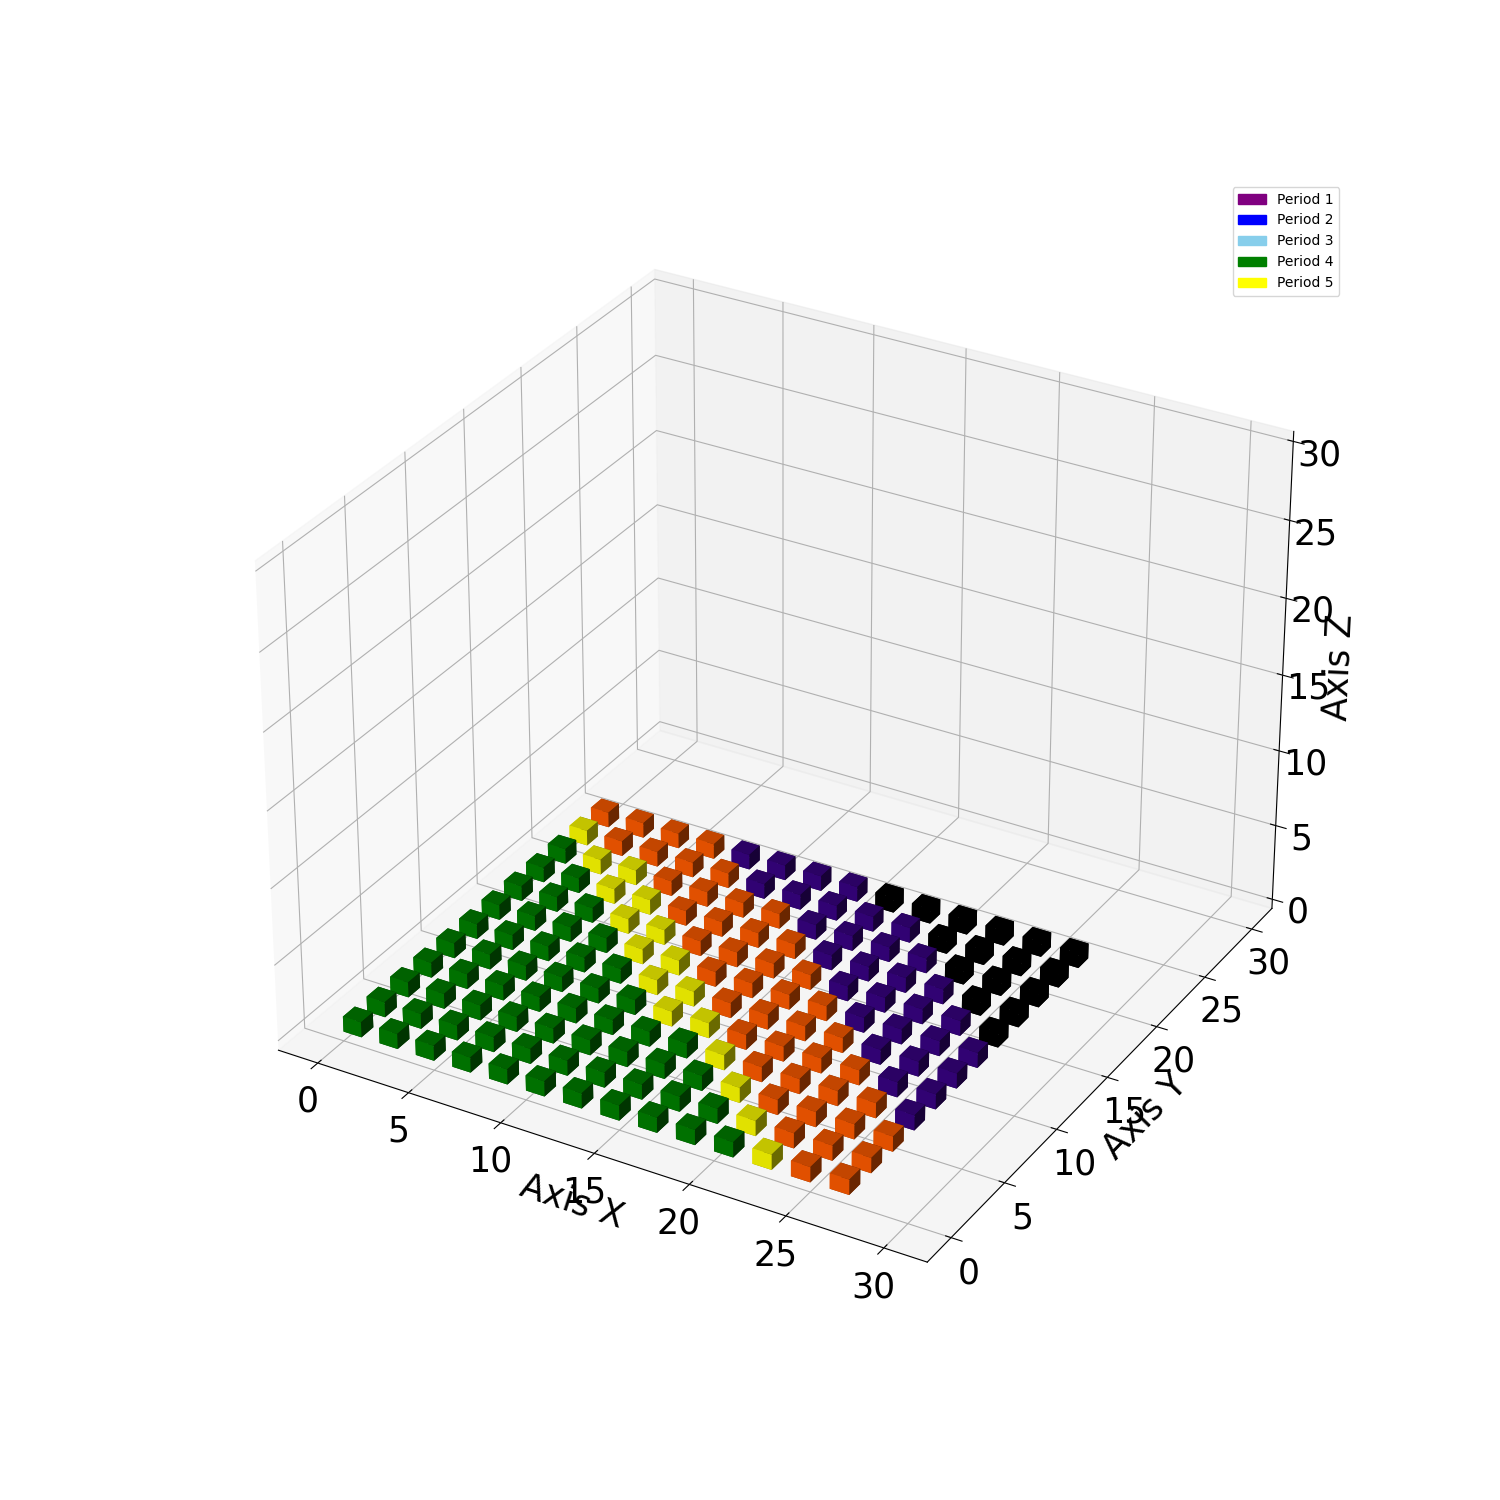

In [14]:
plotDrawpointsPoints(len(main.MasterProblem.drawpoint),main.x_dt_values,main.numberOfPeriods,main.MasterProblem.x_draw,main.MasterProblem.y_draw,main.MasterProblem.z_draw)

In [19]:
# Creamos un diccionario vacío
data_dict = {}

# Abrimos el archivo en modo lectura
with open('openPit_openPit_dbs_duals.TOPOSORT.ip.sol', 'r') as file:
    for line in file:
        # Separamos la línea por espacios
        fields = line.split()

        # Convertimos el primer y tercer campo a int y lo añadimos al diccionario
        key = int(fields[0])
        value = int(fields[2])

        data_dict[key] = value

# Imprimimos el diccionario
print(data_dict)
openPitDict = data_dict

{581206: 2, 581207: 2, 581209: 2, 581317: 2, 581318: 2, 581319: 2, 581320: 2, 581321: 2, 581322: 2, 581323: 2, 581428: 2, 581429: 2, 581430: 2, 581431: 2, 581432: 2, 581433: 2, 581434: 2, 581435: 2, 581436: 2, 581539: 2, 581540: 2, 581541: 2, 581542: 2, 581543: 2, 581544: 2, 581545: 2, 581546: 2, 581547: 2, 581548: 2, 581549: 2, 581650: 2, 581651: 2, 581652: 2, 581653: 2, 581654: 2, 581655: 1, 581656: 1, 581657: 2, 581658: 2, 581659: 2, 581660: 2, 581661: 2, 581662: 2, 581762: 2, 581763: 2, 581764: 2, 581766: 1, 581767: 1, 581768: 1, 581769: 1, 581770: 2, 581771: 2, 581772: 2, 581773: 2, 581774: 2, 581775: 2, 581875: 2, 581876: 2, 581877: 1, 581878: 1, 581879: 1, 581880: 1, 581881: 1, 581882: 1, 581883: 2, 581884: 2, 581885: 2, 581886: 2, 581887: 2, 581888: 2, 581986: 2, 581987: 2, 581988: 1, 581989: 1, 581990: 1, 581991: 1, 581992: 1, 581993: 1, 581994: 1, 581995: 1, 581996: 2, 581997: 2, 581998: 2, 581999: 2, 582000: 2, 582001: 2, 582098: 2, 582099: 2, 582100: 2, 582101: 1, 582102: 1

In [15]:
limites_x_C = main.SubProblem.openPitBlocksLengthLimits 
limites_y_C = main.SubProblem.openPitBlocksWidthLimits 
limites_z_C = main.SubProblem.openPitBlocksHeightLimits 

/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotUndergroundSolution.py:48: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


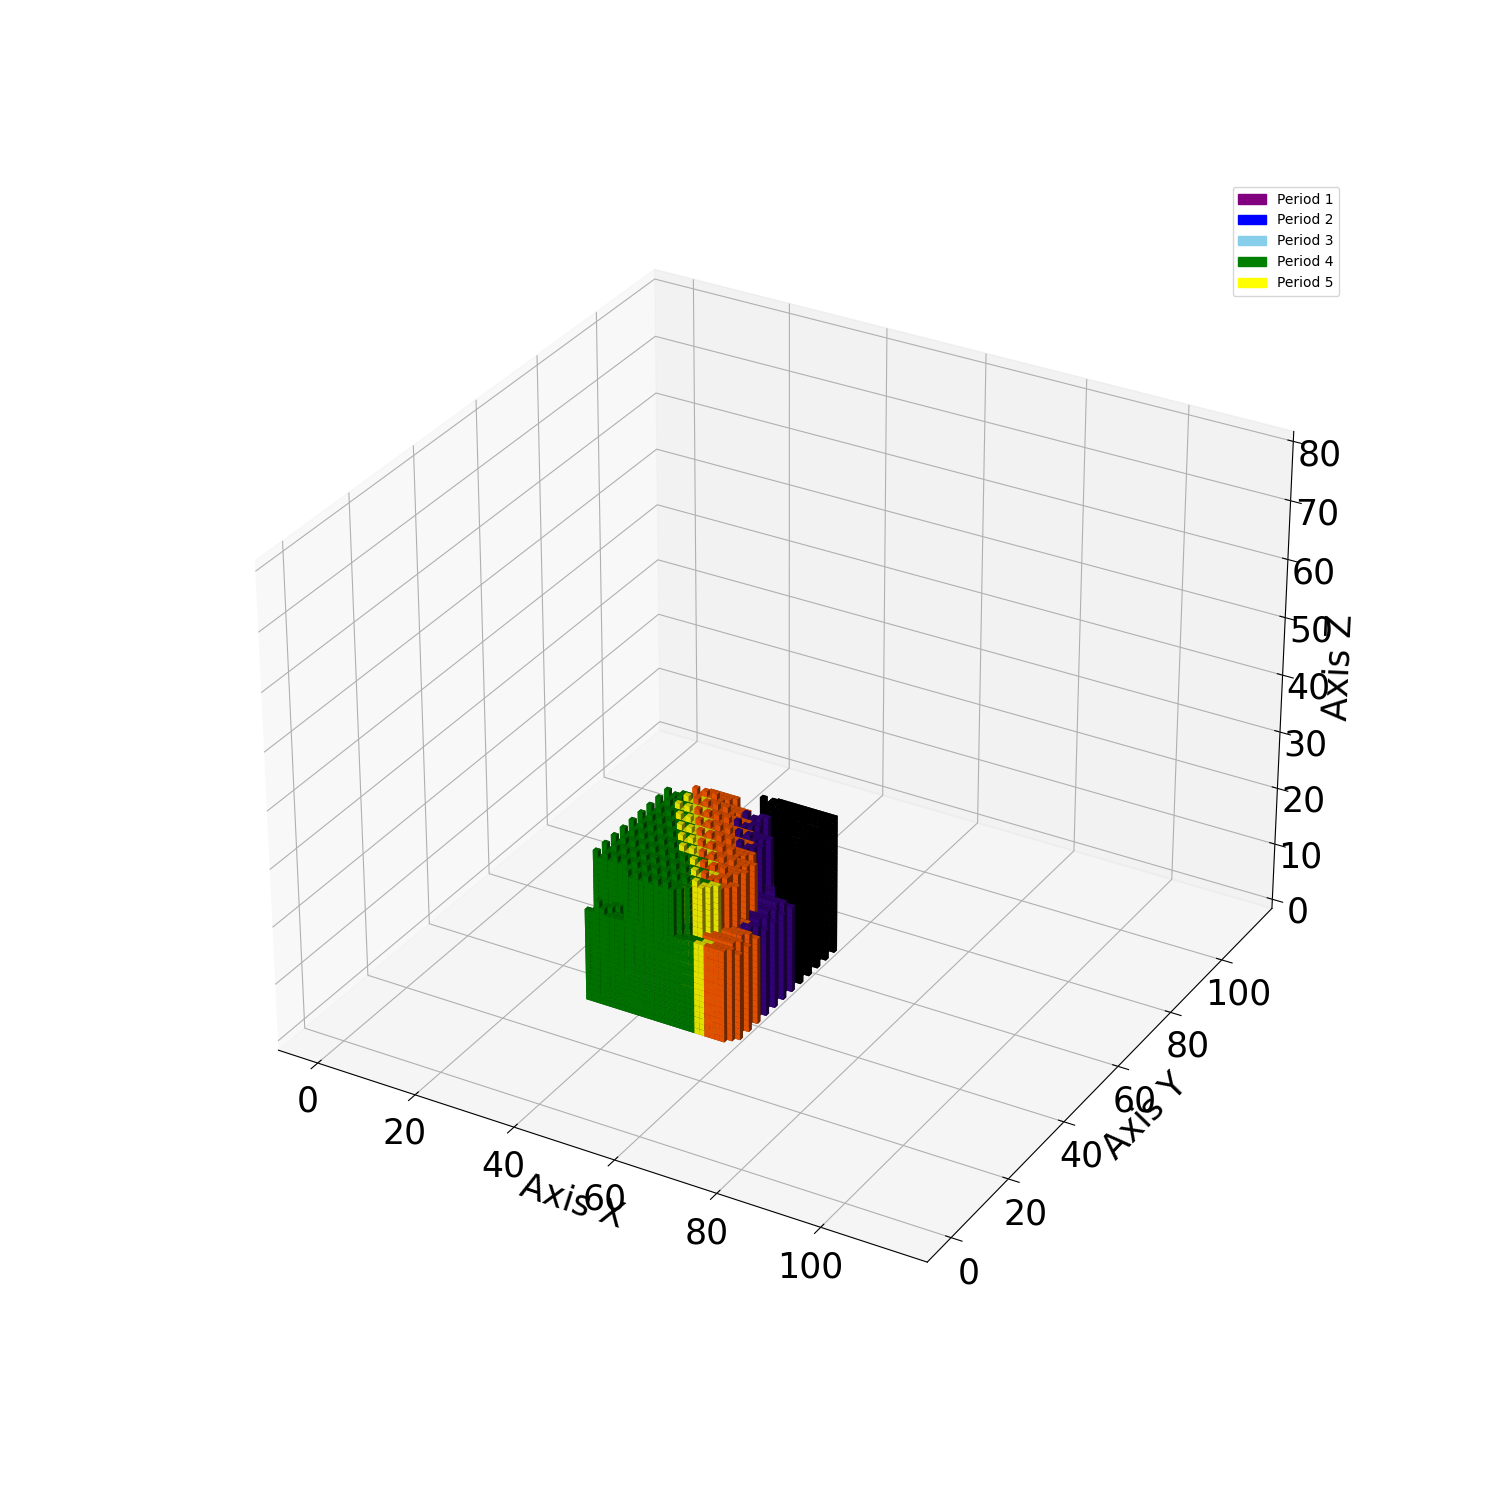

In [17]:
plotUndergroundSolution(main.MasterProblem.undergroundBlocksLenghtLimits, main.MasterProblem.undergroundBlocksWidthLimits,main.MasterProblem.undergroundBlocksHeightLimits, main.MasterProblem.drawpoints_blocks,main.x_dt_values , main.y_dt_values, main.numberOfPeriods)

/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotIntegratedOmpSolution.py:58: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


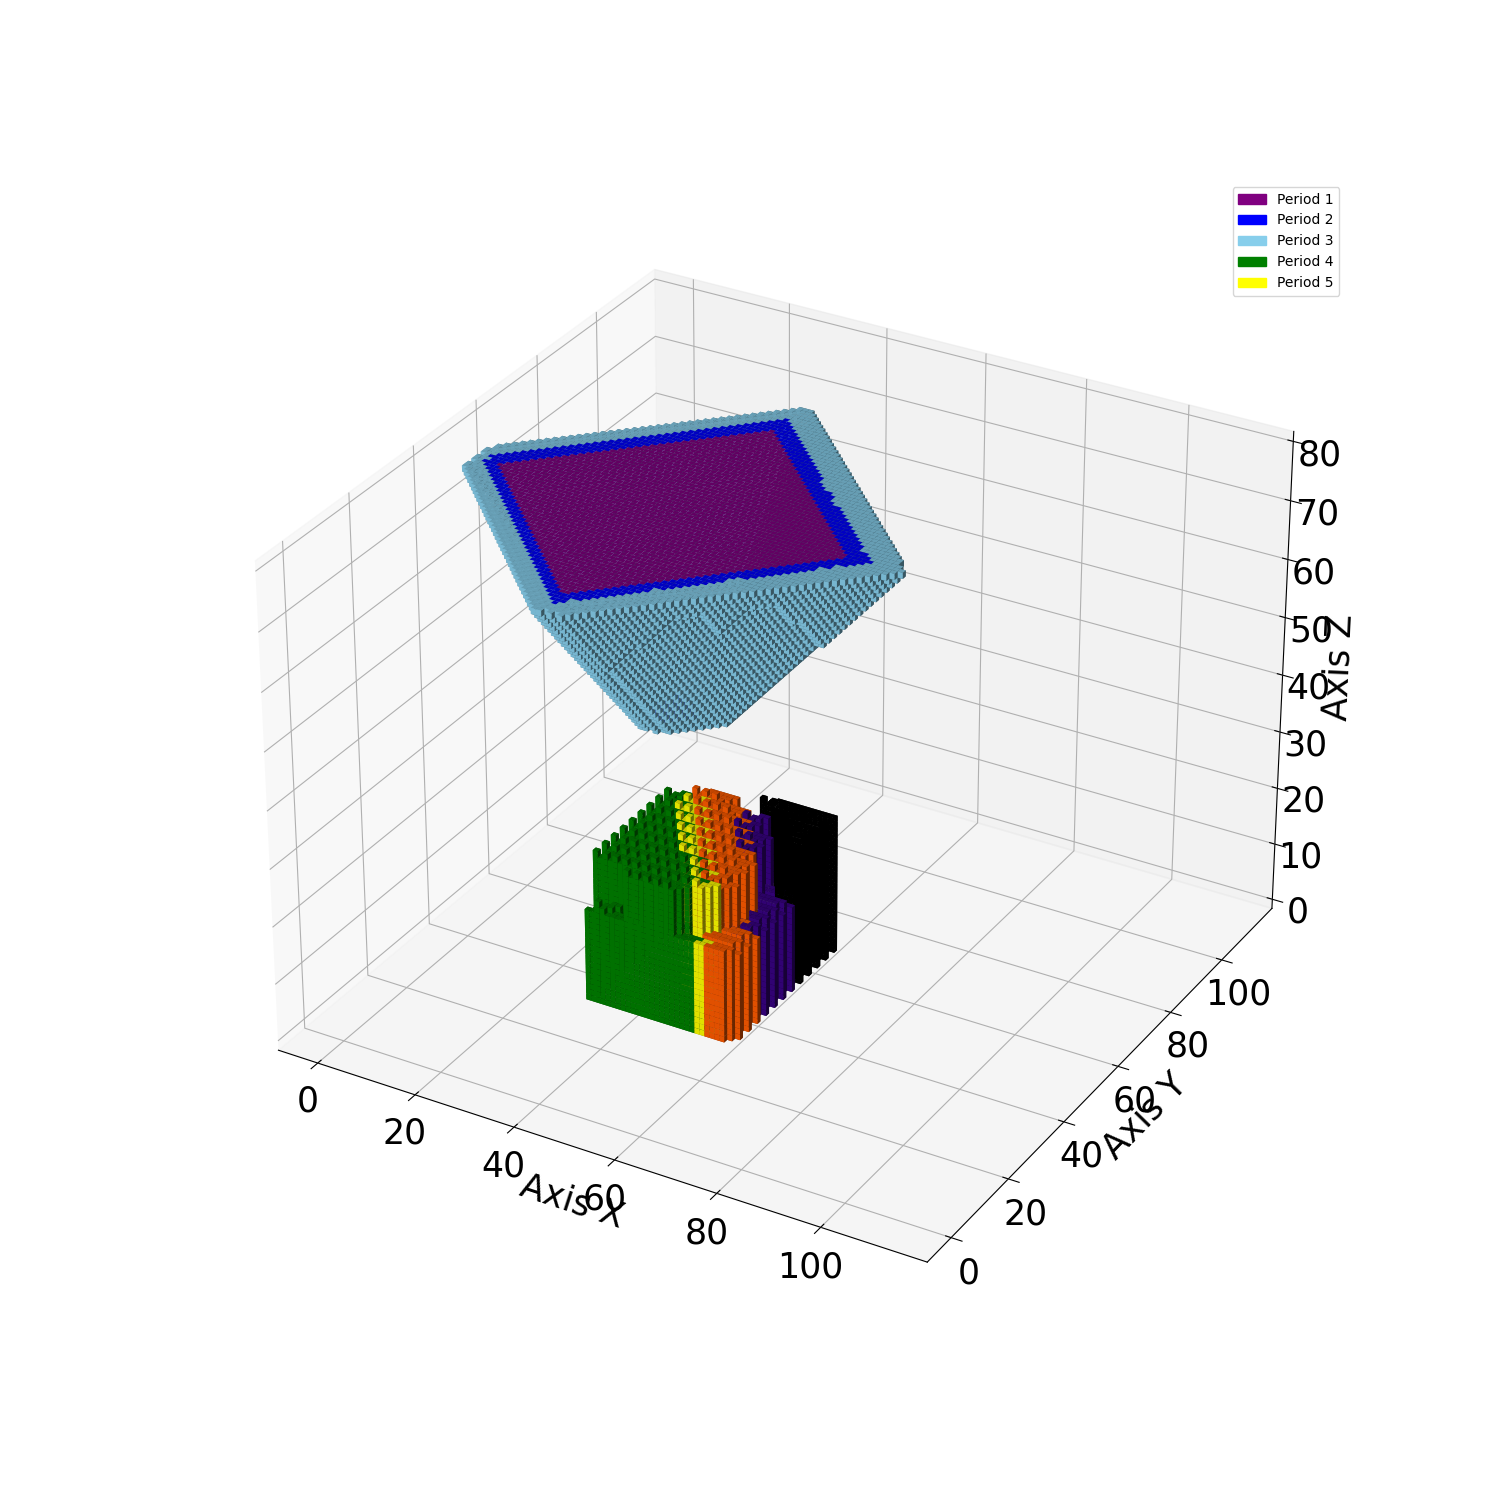

In [20]:
plotIntegratedOmpSolution(main.MasterProblem.undergroundBlocksLenghtLimits, main.MasterProblem.undergroundBlocksWidthLimits,main.MasterProblem.undergroundBlocksHeightLimits, main.MasterProblem.drawpoints_blocks,main.x_dt_values , main.y_dt_values, main.numberOfPeriods,openPitDict)

In [ ]:
main.MasterProblem.undergroundBlocksWidthLimits, main.MasterProblem.undergroundBlocksHeightLimits, main.MasterProblem.undergroundBlocksLenghtLimits

((10, 1360, 250, 112), (10, 1320, 530, 80), (10, 1240, 130, 112))

In [ ]:
perro

NameError: name 'perro' is not defined

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D
from getBlockPosition import getBlockPosition

In [ ]:
voxels = np.zeros((limites_x_C[3], limites_y_C[3], limites_z_C[3]), dtype=bool)

# Creamos una matriz 3D para los colores.
colors_voxels = np.empty(voxels.shape, dtype=object)
for i in range(len(main.MasterProblem.undergroundBlocksLenght)):
        posicion = getBlockPosition(i,limites_x_C,limites_y_C, limites_z_C)#posicionar_dp_CA_S(drawpoint,bloque,x_draw,y_draw,z_draw,limites_x_C, limites_y_C)
        voxels[posicion[0], posicion[1], posicion[2]] = True
        colors_voxels[posicion[0], posicion[1], posicion[2]] = "purple"
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
#ax.set_aspect('auto')
plt.legend(["a"],["b"])
ax.set_xlabel('Axis X',fontsize= 25)
ax.set_ylabel('Axis Y',fontsize= 25)
ax.set_zlabel('Axis Z',fontsize= 25)
ax.zaxis.set_tick_params(labelsize = 25)
ax.xaxis.set_tick_params(labelsize = 25)
ax.yaxis.set_tick_params(labelsize = 25)
ax.voxels(voxels, facecolors=colors_voxels, edgecolor='none')

5 desagregado
Optimal ObjVal: 2742740809.108471
Optimal Theta: 682920000.0
Optimal ObjVal TopoSort: 2742740809.108471
3.2 segs


10 desagregado
Optimal ObjVal: 2268360094.125119
Optimal Theta: 561370000.0
Optimal ObjVal TopoSort: 2268360094.125119
15.4 segs


15 desagregado 
Optimal ObjVal: 1906146810.5342412
Optimal Theta: 469290000.0
Optimal ObjVal TopoSort: 1906146810.5342412 
1min 12 segs



20 desagregado Optimal ObjVal: 1624948384.8196843
Optimal Theta: 399730000.0
Optimal ObjVal TopoSort: 1624948384.8196843
GAP: 0.0 
8min 19.9 segs

10 desagregado

Optimal ObjVal: 2343184937.4682417
Optimal Theta: 640110000.0
Optimal ObjVal TopoSort: 2329594937.4682417
GAP: 0.5799798292781656

5 desagregado

Optimal ObjVal: 2840469882.9332986
Optimal Theta: 781890000.0
Optimal ObjVal TopoSort: 2830099882.9332986
GAP: 0.3650804418771411

15 agregado

Optimal Crown Pillar height: {745: 1.0, 785: 0.0, 825: 0.0, 865: 0.0, 905: 0.0, 945: 0.0, 985: 0.0, 1025: 0.0, 1065: 0.0, 1105: 0.0, 1145: 0.0, 1185: 0.0, 1225: 0.0, 1265: 0.0, 1305: 0.0}
Optimal ObjVal: 1903625419.951932
Optimal Theta: 469290000.0
Optimal ObjVal TopoSort: 1884355419.951932
GAP: 1.0122789808347161

------------------------

VALORES PARA BLOQUES AGREGADOS, SOLUCIÓN RELAJADA


5 PERIODOS: 3.3 segs

* Optimal ObjVal: 2742740809.10847
* Optimal Theta: 682920000.0
* Optimal ObjVal relaxed: 2742740809.108471
* Master problem obj val: 2742740809.108471
* Optimal ObjVal TopoSort: 2742740809.108471

10 PERIODOS: 7.0 segs

* Optimal ObjVal: 2271941260.015317
* Optimal Theta: 561370000.0
* Optimal ObjVal relaxed: 2271941260.015317
* Master problem obj val: 2271941260.015317
* Optimal ObjVal TopoSort: 2271941260.015317
* GAP: 0.0

15 PERIODOS: 14.1 segs

* Optimal ObjVal: 1873723971.8816504
* Optimal Theta: 469290000.0
* Optimal ObjVal relaxed: 1873723971.8816504
* Master problem obj val: 1873723971.8816504
* Optimal ObjVal TopoSort: 1873723971.8816504
* GAP: 0.0

20 PERIODOS: 25.5 segs

* Optimal ObjVal: 1616265630.1377
* Optimal Theta: 399730000.0
* Optimal ObjVal relaxed: 1616265630.1377
* Master problem obj val: 1616265630.1377
* Optimal ObjVal TopoSort: 1616265630.1377
* GAP: 0.0

------------------------

VALORES PARA BLOQUES DESAGREGADOS, SOLUCIÓN RELAJADA


5 PERIODOS: 59.2 segs

* Optimal ObjVal: 2807234376.8134923
* Optimal Theta: 781890000.0
* Optimal ObjVal relaxed: 2807234376.8134923
* Master problem obj val: 2807234376.8134923
* Optimal ObjVal TopoSort: 2807234376.8134923

10 PERIODOS: 1 min 27.3 segs

* Optimal ObjVal: 2353537399.199758
* Optimal Theta: 640110000.0
* Optimal ObjVal relaxed: 2353537399.199758
* Master problem obj val: 2353537399.199758
* Optimal ObjVal TopoSort: 2353537399.199758
* GAP: 0.0

15 PERIODOS: 2 min 10.2 segs

* Optimal ObjVal: 1962744919.4705706
* Optimal Theta: 532320000.0
* Optimal ObjVal relaxed: 1962744919.4705706
* Master problem obj val: 1962744919.4705706
* Optimal ObjVal TopoSort: 1962744919.4705706
* GAP: 0.0

20 PERIODOS: 3 min 0.9 segs

* Optimal ObjVal: 1657095434.8418837
* Optimal Theta: 449440000.0
* Optimal ObjVal relaxed: 1657095434.8418837
* Master problem obj val: 1657095434.8418837
* Optimal ObjVal TopoSort: 1657095434.8418837
* GAP: 0.0

------------------------

VALORES PARA BLOQUES AGREGADOS, SOLUCIÓN ENTERA


5 PERIODOS: 3.2 segs

* Optimal ObjVal: 2742740809.108471
* Optimal Theta: 682920000.0
* Optimal ObjVal relaxed: 2742740809.108471
* Master problem obj val: 2742740809.108471
* Optimal ObjVal TopoSort: 2686060809.108471
* GAP: 2.0665459824628436

10 PERIODOS: 7.0 segs

* Optimal ObjVal: 2271941260.015317
* Optimal Theta: 561370000.0
* Optimal ObjVal relaxed: 2271941260.015317
* Master problem obj val: 2271941260.015317
* Optimal ObjVal TopoSort: 2228841260.015317
* GAP: 1.8970560884883718

15 PERIODOS: 13.9 segs
* Optimal ObjVal: 1873723971.8816504
* Optimal Theta: 469290000.0
* Optimal ObjVal relaxed: 1873723971.8816504
* Master problem obj val: 1873723971.8816504
* Optimal ObjVal TopoSort: 1854453971.8816504
* GAP: 1.0284332318515668

20 PERIODOS: 25.3 segs 

* Optimal ObjVal: 1616265630.1377
* Optimal Theta: 399730000.0
* Optimal ObjVal relaxed: 1616265630.1377
* Master problem obj val: 1616265630.1377
* Optimal ObjVal TopoSort: 1593475630.1377
* GAP: 1.4100405017001056

------------------------

VALORES PARA BLOQUES DESAGREGADOS, SOLUCIÓN ENTERA


5 PERIODOS: 3.3 segs

* Optimal ObjVal: 2807234376.8134923
* Optimal Theta: 781890000.0
* Optimal ObjVal relaxed: 2807234376.8134923
* Master problem obj val: 2807234376.8134923
* Optimal ObjVal TopoSort: 2796864376.8134923
* GAP: 0.3694027148446025

10 PERIODOS: 1 min 27.7 segs

* Optimal ObjVal: 2353537399.199758
* Optimal Theta: 640110000.0
* Optimal ObjVal relaxed: 2353537399.199758
* Master problem obj val: 2353537399.199758
* Optimal ObjVal TopoSort: 2339947399.199758
* GAP: 0.5774286826553436

15 PERIODOS: 2 min 9.8 segs

* Optimal ObjVal: 1962744919.4705706
* Optimal Theta: 532320000.0
* Optimal ObjVal relaxed: 1962744919.4705706
* Master problem obj val: 1962744919.4705706
* Optimal ObjVal TopoSort: 1941014919.4705706
* GAP: 1.1071229778478517

20 PERIODOS: 2 min 59.9 segs

* Optimal ObjVal: 1657095434.8418837
* Optimal Theta: 449440000.0
* Optimal ObjVal relaxed: 1657095434.8418837
* Master problem obj val: 1657095434.8418837
* Optimal ObjVal TopoSort: 1640575434.8418837
* GAP: 0.9969250806352201

------------------------